In [1]:
# Install transformers and thai2transformers
!pip install transformers
!pip install -q emoji pythainlp==2.2.4 sefr_cut tinydb seqeval sentencepiece pydantic jsonlines
!pip install --no-deps thai2transformers==0.1.2
!pip install evaluate

  Using cached evaluate-0.4.2-py3-none-any.whl.metadata (9.3 kB)
Using cached evaluate-0.4.2-py3-none-any.whl (84 kB)


In [2]:
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, Trainer, TrainingArguments, TrainerCallback
from datasets import load_dataset, load_metric
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset, load_metric
import matplotlib.pyplot as plt
import evaluate

2024-07-14 06:32:51.307505: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-14 06:32:51.307630: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-14 06:32:51.476169: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Load tokenizer and model
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels=2)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
import pandas as pd
df = pd.read_csv('/kaggle/input/ticket/data.csv')
df.drop(columns=['Unnamed: 0'])
df['text'] = df['clean_subject'] + ' ' + df['clean_description']

In [5]:
data = df[['ticket_type','text']]
data = data[data['ticket_type'] != 'Problem'] #Drop Class Problem
data.dropna(subset=['text'], inplace=True)

In [45]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load data and preprocess
df = pd.read_csv('/kaggle/input/ticket/data.csv')
df = df.drop(columns=['Unnamed: 0'])  # Dropping the unnamed column
df['text'] = df['clean_subject'] + ' ' + df['clean_description']
data = df[['ticket_type', 'clean_subject', 'clean_description', 'text']]
data = data[data['ticket_type'] != 'Problem']  # Drop Class Problem
data.dropna(subset=['text'], inplace=True)

# Encode labels as integers
label2id = {'Incident': 0, 'Request': 1}
data['labels'] = data['ticket_type'].map(label2id)

# Sample 50,000 from each class
df_request = data[data['ticket_type'] == 'Request'].sample(n=50000, random_state=42)
df_incident = data[data['ticket_type'] == 'Incident'].sample(n=50000, random_state=42)
df_balanced = pd.concat([df_request, df_incident]).reset_index(drop=True)

# Split the data into train+val and test sets
train_val_data, test_data = train_test_split(df_balanced, test_size=0.2, random_state=42)

# Further split train+val into train and val sets
train_data, val_data = train_test_split(train_val_data, test_size=0.25, random_state=42)

# Extract the test texts, subjects, and descriptions
test_texts = test_data['text'].tolist()
test_subjects = test_data['clean_subject'].tolist()
test_descriptions = test_data['clean_description'].tolist()
test_labels = test_data['labels'].tolist()

# Create a new dataframe for the test set with original subjects and descriptions
test_df = pd.DataFrame({
    'subject': test_subjects,
    'description': test_descriptions,
    'text': test_texts,
    'labels': test_labels
})

# Display the test dataframe
test_df.head()

,subject,description,text,labels
0,noc ได้รับ alert vm มีสถานะ down no response ...,prtg network monitor sensor rdp ) probe in...,noc ได้รับ alert vm มีสถานะ down no response ...,0
1,op nx wiphusit songwutsin noc ได้รับ alert ...,resolved wiphusit songwutsin wipusit sp wiphu...,op nx wiphusit songwutsin noc ได้รับ alert ...,0
2,closed itopplus bcp เพิ่ม allow policy firew...,noc รบกวนทีม noc ประสานงานทีมเพื่อดำเนินการเพิ...,closed itopplus bcp เพิ่ม allow policy firew...,1
3,noc ได้รับ alert vm tst hc db dsm มีก...,prtg network monitor sensor memory physical m...,noc ได้รับ alert vm tst hc db dsm มีก...,0
4,op sec jtekt asia pacific ตรวจสอบ openvpn ข...,ทีม noc รบกวนตรวจสอบ openvpn ของ jtekt asiapac...,op sec jtekt asia pacific ตรวจสอบ openvpn ข...,0


In [53]:
import re
test_df = pd.read_csv('/kaggle/working/test200.csv')
test_df_sample = test_df.sample(n=200, random_state=42)
test_df_sample = test_df_sample[['subject', 'description']]
def remove_non_ascii(text):
    return re.sub(r'[^\x00-\x7F]+', '', text)
test_df_sample['subject'] = test_df_sample['subject'].apply(remove_non_ascii)
test_df_sample['description'] = test_df_sample['description'].apply(remove_non_ascii)
test_df_sample.to_csv('test200.csv', encoding='ascii', index=False)

print("Sample saved to test200.csv")

Sample saved to test200.csv


In [6]:
tokenizer

XLMRobertaTokenizer(name_or_path='xlm-roberta-base', vocab_size=250002, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	250001: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}

In [8]:
model

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768,

In [9]:
# Encode labels as integers
label2id = {'Incident': 0, 'Request': 1}
data['labels'] = data['ticket_type'].map(label2id)

In [10]:
# Sample 50,000 from each class
df_request = data[data['ticket_type'] == 'Request'].sample(n=50000, random_state=42)
df_incident = data[data['ticket_type'] == 'Incident'].sample(n=50000, random_state=42)
df_balanced = pd.concat([df_request, df_incident]).reset_index(drop=True)

In [11]:
# Split the data into train+val and test sets
train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(
    df_balanced['text'].tolist(), df_balanced['labels'].tolist(), test_size=0.2, random_state=42)

# Further split train+val into train and val sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_val_texts, train_val_labels, test_size=0.25, random_state=42)


In [12]:
print(df_balanced['ticket_type'].value_counts())

ticket_type
Request     50000
Incident    50000
Name: count, dtype: int64


In [13]:
# Tokenize data
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)

# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_dict({'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask'], 'labels': train_labels})
val_dataset = Dataset.from_dict({'input_ids': val_encodings['input_ids'], 'attention_mask': val_encodings['attention_mask'], 'labels': val_labels})
test_dataset = Dataset.from_dict({'input_ids': test_encodings['input_ids'], 'attention_mask': test_encodings['attention_mask'], 'labels': test_labels})

In [16]:
from transformers import TrainingArguments, EarlyStoppingCallback
import os
os.environ["WANDB_DISABLED"] = "true"

# Define training arguments without WandB
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=1000,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [17]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
import evaluate

# Load metric
accuracy_metric = evaluate.load("accuracy")

# Custom callback for collecting loss and accuracy
class CustomCallback(TrainerCallback):
    def __init__(self):
        self.losses = []
        self.accuracies = []

    def on_epoch_end(self, args, state, control, **kwargs):
        output = trainer.evaluate(eval_dataset=val_dataset)
        self.losses.append(output["eval_loss"])
        self.accuracies.append(output["eval_accuracy"])

# Initialize the callback
callback = CustomCallback()

# Define trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=lambda p: {"accuracy": accuracy_metric.compute(predictions=p.predictions.argmax(-1), references=p.label_ids)["accuracy"]},
    callbacks=[callback, EarlyStoppingCallback(early_stopping_patience=3)]
)

In [18]:
# Train the model 03e121b5249ddc41bae22e9ba18fbb65bed41b1e
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,0.154200,0.150722,0.965650
2,0.117500,0.143701,0.967000
3,0.113400,0.152892,0.964850
4,0.096100,0.140892,0.966150
5,0.071400,0.176088,0.966450


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

TrainOutput(global_step=37500, training_loss=0.1123472427368164, metrics={'train_runtime': 27850.3201, 'train_samples_per_second': 10.772, 'train_steps_per_second': 1.346, 'total_flos': 7.8933316608e+16, 'train_loss': 0.1123472427368164, 'epoch': 5.0})

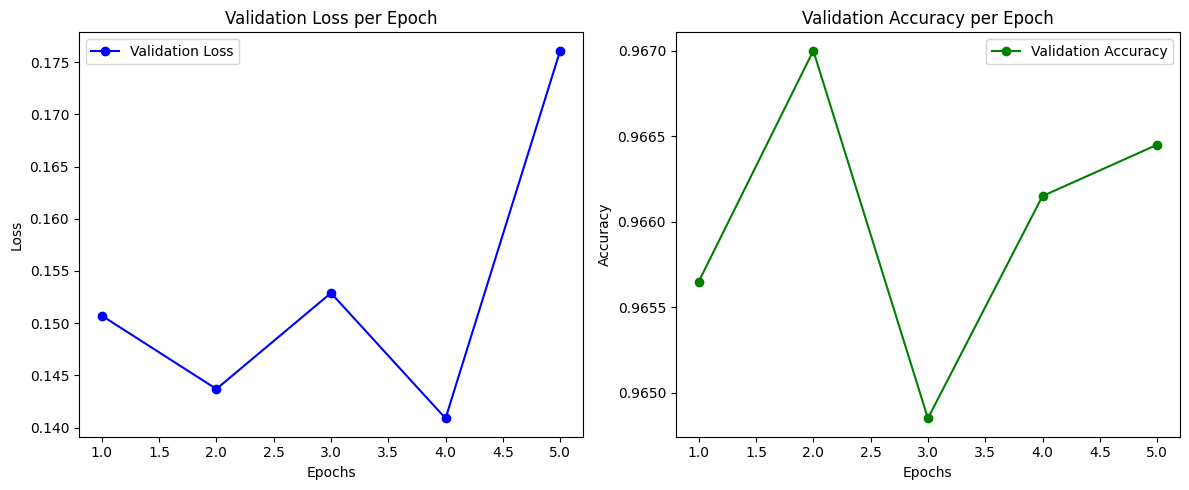

In [19]:
# Plot loss and accuracy
epochs = range(1, len(callback.losses) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, callback.losses, 'bo-', label='Validation Loss')
plt.title('Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, callback.accuracies, 'go-', label='Validation Accuracy')
plt.title('Validation Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_metrics.png')
plt.show()

In [20]:
# Evaluate the model on validation set
val_results = trainer.evaluate(eval_dataset=val_dataset)
print("Validation results:", val_results)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Validation results: {'eval_loss': 0.17608828842639923, 'eval_accuracy': 0.96645, 'eval_runtime': 562.1051, 'eval_samples_per_second': 35.581, 'eval_steps_per_second': 4.448, 'epoch': 5.0}


In [ ]:
# # Evaluate the model on test set
# test_results = trainer.evaluate(eval_dataset=test_dataset)
# print("Test results:", test_results)

In [34]:
from transformers import AutoModel, AutoTokenizer
model = AutoModel.from_pretrained('/kaggle/working/xlm-roberta-trained/model')
tokenizer = AutoTokenizer.from_pretrained('/kaggle/working/xlm-roberta-trained/token')

# Save the model in safetensors format
model.save_pretrained('/kaggle/working/xlm-roberta-trained/model', safe_serialization=True)
# Save the tokenizer (tokenizer save_pretrained doesn't change)
tokenizer.save_pretrained('/kaggle/working/xlm-roberta-trained/token')

Some weights of XLMRobertaModel were not initialized from the model checkpoint at /kaggle/working/xlm-roberta-trained/model and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


('/kaggle/working/xlm-roberta-trained/token/tokenizer_config.json',
 '/kaggle/working/xlm-roberta-trained/token/special_tokens_map.json',
 '/kaggle/working/xlm-roberta-trained/token/sentencepiece.bpe.model',
 '/kaggle/working/xlm-roberta-trained/token/added_tokens.json',
 '/kaggle/working/xlm-roberta-trained/token/tokenizer.json')

In [35]:
model

XLMRobertaModel(
  (embeddings): XLMRobertaEmbeddings(
    (word_embeddings): Embedding(250002, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): XLMRobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x XLMRobertaLayer(
        (attention): XLMRobertaAttention(
          (self): XLMRobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): XLMRobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=Tru

In [23]:
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification

# Load the tokenizer and model
tokenizer = XLMRobertaTokenizer.from_pretrained('/kaggle/working/xlm-roberta-trained/token')
model = XLMRobertaForSequenceClassification.from_pretrained('/kaggle/working/xlm-roberta-trained/model')


In [ ]:
!pip install safetensors

## Performance on TestDataset

In [42]:
# Check class balance in test_dataset
test_labels = test_dataset['labels']  # Adjust this if your dataset structure is different
class_balance = pd.Series(test_labels).value_counts()
print("Class Balance in Test Dataset:")
print(class_balance)

Class Balance in Test Dataset:
1    10035
0     9965
Name: count, dtype: int64


In [41]:
test_texts[0]

"noc ได้รับ alert vm มีสถานะ down no response   ping down   remote desktop down จำนวนมาก เมื่อ  october      pm prtg network monitor sensor rdp )     probe internal prtg probes  srb new   group softway consulting   c    project smartvdi com   device  idc  srb intel prd  comdb   com vdi poc    new status at       pm   down last message  connection refused socket error    connection refused  last scan  last up  last down  uptime  downtime  coverage  sensor type  interval   m  s  d  m  s         rdp  s scan now acknowledge alarm pause resume pause for  minutes pause for  minutes pause for  hours graph graph graph channel last value downtime response time no data history       pm down connection refused socket error    connection refused        pm unknown no data since       pm don't want to receive this email? please edit the notification triggers of this sensor or edit your notification template settings  sent       pm to by prtg network monitor ( prtg network monitor         paessler ag

In [43]:
from sklearn.metrics import classification_report

# Get predictions
predictions = trainer.predict(test_dataset)
pred_labels = predictions.predictions.argmax(-1)

# Assuming you have the true labels in the test dataset
true_labels = test_dataset['labels']  # Adjust this if your dataset structure is different

# Generate classification report
report = classification_report(true_labels, pred_labels, target_names=['Incident', 'Request'])
print("Classification Report:")
print(report)

KeyboardInterrupt: 

# Attention Visualization
> Shows which tokens the model is focusing on (if applicable).